In [ ]:
import os
import numpy
import random
import matplotlib.pyplot
os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_1\Intelligent Systems\HWA\KP instances")

In [ ]:
# Generator/Selection of PIs
def instances(n, kp_limit):
    if kp_limit != 0: # If a knapsack limit is defined, instances are generated
        PIs = []
        for element in range(n):
            PIs.append((random.uniform(1.0, 15.0), random.randint(1, kp_limit//3))) # (value (1-15), weight (1 - 1/3kp))
        return PIs, kp_limit
    else: # When the knapsack limit is not defined, then a instance from the library is used
        import os
        os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_1\Intelligent Systems\HWA\KP instances")
        fileName = f'ks_{n}_0' # Introduces the PIs number into the filename that will be requested
        f = open(fileName, "r")
        lines = f.readlines()
        line = lines[0].split(",")
        nbItems = int(line[0].strip())
        maxWeight = int(line[1].strip())
        items = [None] * nbItems
        for i in range(0, nbItems):
            line = lines[i + 1].split(",")
            weight = int(line[0].strip())
            profit = float(line[1].strip())
            items[i] = (profit, weight) # Shifts order from (weight, profit) to (weight, profit)
        problem = (maxWeight, items) # Problem stores, maxweight and items
        PIs = list() # Creates a new list for the PIs
        for element in problem[1]: # Each  item properties
            PIs.append(element) # Stores/isolates the items properties in a new list
        kp_limit = problem[0] # Stores/isolates the kp limit in a new variable
        return PIs, kp_limit # Returns the items properties and the kp limit 

In [ ]:
# Cellular Automata Solution Generator Function
def CA(rules, PIs):

    initial_states = []
    rules_outcome = []
    number_rules = len(rules)
    neighborhood = len(rules[0])
    number_kp_items = len(PIs)

    for element in range(number_kp_items): # Appends a set of zeros with the same length of the set of knapsack items to the initial states, and a set of 1s for the rules outcome
        if element == number_kp_items // 2 - 1:
            initial_states.append(1) # The initial state is an active cell in the middle, for example for a PI of 7 available items: [0 0 0 1 0 0 0]
        else:
            initial_states.append(0)
    
    for element in range(number_rules): # Appends a set of 1s for the rules outcome
        rules_outcome.append(1)

    generations = 1 # Defines the number of generations that will be produced, 1 generation is 1 solution
    rows = generations + 1 # The number of rows is the same as the initial state row plus the number of generations
    columns = len(initial_states) # The number of columns is the same as the number of kp availabl items

    import numpy # To compute the CA with an array with zeros
    canvas = numpy.zeros([rows, columns]) # Creates the array where the CA will be computed

    for i in range(len(initial_states)):
        canvas[0, i] = initial_states[i] # Places the parent in the CA array
    
    for i in range(rows - 1): #  Iterates the whole canvas
        for j in range(columns):
            for k in range(number_rules):
                if numpy.array_equal(rules[k], canvas[i, j:(j + neighborhood)]): #Compares with the rules, if it matches:...
                    canvas[i + 1, j + 1] = rules_outcome[k] # ...substitutes the canvas with the outcome
                    
    import matplotlib.pyplot as plt # For plotting the CA
    # plt.imshow(canvas[:, 0:columns], cmap='Greys', interpolation='nearest')
    
    result = []
    
    for element in canvas[1:].tolist()[0]:
        result.append(element) # Appends the generated generation, or the generated solution in the result list
    return result # Returns the solution

In [ ]:
# Rule Splitter
def CA_Rules(rules, size):    
    start = 0
    end = len(rules)
    step = size
    new_rules = []
    
    for i in range(start, end, step): # Breaks the 0s and 1s in sublists of 'size' length
        x = i
        new_rules.append(rules[x : x + step])
    return new_rules

In [ ]:
# Individual initialization
def createIndividual(rules_digits): # Receives the required number of random binary-numbers to generate: 'n'
  return numpy.random.randint(0, 2, rules_digits) # Returns the generated random binary-numbers

In [ ]:
# Crossover operator
def combine(parentA, parentB, cRate): # Receives two parents and a crossover rate
  import random # To create random float numbers between 0 and 1
  if (random.random() <= cRate): # Compares crossover rate with random rate, in case the cRate is larger or equal executes:
    cPoint = numpy.random.randint(1, len(parentA)) # Creates a random number between 1 and the parents length to be the crossover point
    offspringA = numpy.append(parentA[0:cPoint], parentB[cPoint:]) # Joins splitted parents at the crosspoint as the offspring
    offspringB = numpy.append(parentB[0:cPoint], parentA[cPoint:])
  else:
    offspringA = numpy.copy(parentA) # Copies the whole parent as the offspring when the crossover rate is smaller not equal to the random rate 
    offspringB = numpy.copy(parentB) 
  return offspringA, offspringB  # Returnes the offspring, result of the combination or copying of the parents

In [ ]:
# Mutation operator
def mutate(individual, mRate): # Receives the mutation rate and an individual (Set of random numbers between 0-1)
  for i in range(len(individual)): # Iterates the numbers from 0 up to the length of the individual
    if (random.random() <= mRate): # Compares mutation rate with random rate, in case the mRate is larger or equal executes:
      individual[i] = not(individual[i]) # Switches 0s for 1s and the other way around
  return individual # Returnes mutated individual

In [ ]:
# Evaluation function # It was changed
def evaluate(PIs, individual, kp_limit, size_rules): # Receives P which is the list of available items, kp_limit is the max size that the knapsack can hold
    s1 = (0, 0) # A tuple that stores value/profit and weight (value, weight)
    rules = CA_Rules(individual, size_rules)
    new_individual = CA(rules, PIs)
    for i in range(len(PIs)): # Iterates from 0  to the number of the available items in the list P
        if new_individual[i] == 1: # When individual is 1 (inside the knapsack) executes: 
            s1 = (s1[0] + PIs[i][0], s1[1] + PIs[i][1]) # Sums up the value and the weight in the s1 tuple
    return s1, new_individual

In [ ]:
# Tournament selection # It was changed
def select(population, evaluation, tSize): # Receives population, evaluation and tSize
  winner = numpy.random.randint(0, len(population)) # Assigns as the winner a random number (index) between 0 and the length of the population
  for i in range(tSize - 1): # Iterates from 0 to the tournament size minus 1
    rival = numpy.random.randint(0, len(population)) # Assigns as the rival a random number (index) between 0 and the length of the population
    if (evaluation[rival][0] > evaluation[winner][0]): # When the rival value/profit is larger than the winner value/profit executes:
      winner = rival # Assigns the rival index as the winner
  return population[winner] # Returns the winner of the population

In [ ]:
# Dooming of individuals
def extinguish(population, evaluation, CApopulation, kp_limit): # Receives population, evaluation and the knapsack weight limit
    index_list = []
    for i in range(len(evaluation)):
        if evaluation[i][1] > kp_limit:
            index_list.append(i)
    for index in sorted(index_list, reverse = True):
        del population[index]
        del evaluation[index]
        del CApopulation[index]
    return population, evaluation, CApopulation

In [ ]:
# Evolutionary Process, Genetic Algorithm
from numpy import delete
def geneticAlgorithm(PIs, population_size, generations, cRate, mRate, kp_limit, size_rules, number_rules): # It was changed
  
  rules_digits = size_rules*number_rules
  population = []
  CApopulation = []
  evaluation = []
  noneindexes = []
 
  for i in range(population_size):
    population.append(createIndividual(rules_digits))
    evaluation.append(evaluate(PIs, population[i], kp_limit, size_rules)[0]) # It was changed
    CApopulation.append(evaluate(PIs, population[i], kp_limit, size_rules)[1])
  
  population, evaluation, CApopulation = extinguish(population, evaluation, CApopulation, kp_limit) # Kills the indivuals that exceed the kp_limit size
  population_size = len(population)
  # Keeps a record of the best individual found so far
  index = 0;
  for i in range(1, population_size):
    if (evaluation[i][0] > evaluation[index][0]): # It was changed
      index = i;
  bestIndividual = population[index]
  bestCAIndividual = CApopulation[index]
  bestEvaluation = evaluation[index][0] # It was changed
  # Keeps the information for plotting the performance of the algorithm
  best = [0] * generations
  avg = [0] * generations  
  # Runs the evolutionary process
  for i in range(generations):
    # if population_size % 2 != 0: # It was added # For some reason if the population is odd the code crashes, so I fixed the population size
    #   population_size = population_size - 1
    newPopulation = []
    # Crossover
    for j in range(population_size // 2):
      parentA = select(population, evaluation, 3)
      parentB = select(population, evaluation, 3)
      offspring1, offspring2 = combine(parentA, parentB, cRate)
      newPopulation.append(offspring1)
      newPopulation.append(offspring2)
    population = newPopulation
    population_size = len(population)
    # Mutation
    noneindexes = []
    for j in range(population_size):    
      population[j] = mutate(population[j], mRate)
      evaluation[j] = evaluate(PIs, population[j], kp_limit, size_rules)[0] # It was changed # Added kp_limit
      CApopulation[j] = evaluate(PIs, population[j], kp_limit, size_rules)[1]
    population, evaluation, CApopulation = extinguish(population, evaluation, CApopulation, kp_limit) # Kills the indivuals that exceed the kp_limit size
    population_size = len(population)
    for j in range(population_size):
      # Keeps a record of the best individual found so far
      if (evaluation[j][0] > bestEvaluation): # It was changed
        bestEvaluation = evaluation[j][0] # It was changed
        bestIndividual = population[j]
        bestCAIndividual = CApopulation[j]
      best[i] = bestEvaluation
      avg[i] = numpy.average([item[0] for item in evaluation]) # It was changed
  matplotlib.pyplot.plot(range(generations), best, label = "Best")
  matplotlib.pyplot.plot(range(generations), avg, label = "Average")
  matplotlib.pyplot.legend()
  matplotlib.pyplot.title("GA Run")
  matplotlib.pyplot.show()
  # Returns the best individual found so far
  return bestIndividual, bestEvaluation, bestCAIndividual, evaluation  

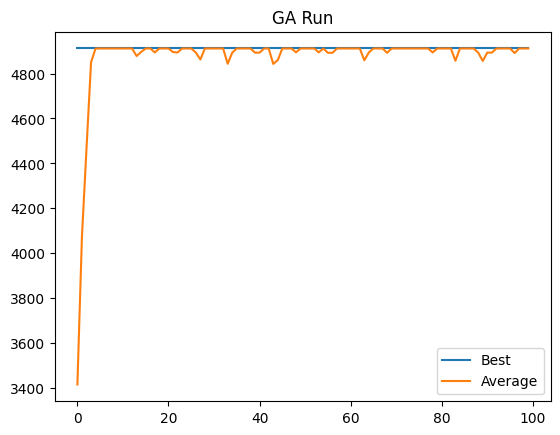

The maximum knapsack weight limit is:
31181
The solution is:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The total profit is:
4912.0


In [ ]:
PIs, kp_limit = instances(19, 0) #(Number_PIs, kp_limit), if kp_limit is 0, a PIs from the library will be selected
rule, eval, solution, evaluation = geneticAlgorithm(PIs, 100, 100, 0.001, 0.001, kp_limit, 3, 4) # (PIs, population_size, generations, cRate, mRate, kp_limit, size_rules, number_rules)
print('The maximum knapsack weight limit is:')
print(kp_limit)
print('The solution is:')
print(solution)
print('The total profit is:')
print(eval)

In [ ]:
# Generator of Random Rules
def rule_generator(number_rules, size):
    rules = []
    number = number_rules * size

    for element in range(number):
        rules.append(random.randint(0, 2)) # Appends 0s or 1s that complete the number of rules
    
    start = 0
    end = len(rules)
    step = size
    new_rules = []
    
    for i in range(start, end, step): # Breaks the 0s and 1s in sublists of 'size' length
        x = i
        new_rules.append(rules[x : x + step])
    return new_rules

In [ ]:
# Evaluation of Solutions Function
def evaluate2(PIs, solution, kp_limit): # PI is my list of available items, kp is the max size the knapsack can hold
    s1 = (0, 0, 0) # (profit, weight, broken knapsack)
    for i in range(len(PIs)): # Iterates all the objects
        if solution[i] == 1: # Individual of 1, means position i object is in the knapsack
            s1 = (s1[0] + PIs[i][0], s1[1] + PIs[i][1]) # Sums up the profit and the weight, it also registers if the knapsack is broken inside the s1 tuple
    if s1[1] <= kp_limit: # 0 If the knapsack is not broken
        s1 = (s1[0], s1[1], 0)
    else:
        s1 = (s1[0], s1[1], 1) # 1 Knapsack exceeds in size
    return s1

In [ ]:
# Tester Function
def tester(number_rules, size_rules, PIs, kp_limit, sample_size):

    solutions = [] 

    for i in range(sample_size): # Produces sample_size number of solutions
        rules = rule_generator(number_rules, size_rules) # Generates random rules 
        solution = CA(rules, PIs) # Creates a solution for the random PI with the random rules
        evaluation = evaluate2(PIs, solution, kp_limit) # Evaluates the generated solutions
        solutions.append((evaluation, solution)) # Returns a list of tuples with the evaluation tuple and the solution list (((0, 0 , 1), [0, 1, 0, 0, 1]),...)
        
    return solutions

In [ ]:
 # Analyzes the tests
 def test_analysis(number_rules, size_rules, PIs, kp_limit, sample_size):
    
    results = []
    
    for i in range(1, sample_size + 1): # Executes tests of the sample_size - 1 till reaching 1
        solutions = tester(number_rules, size_rules, PIs, kp_limit, i)
        count1 = 0 # Profit Counter
        count2 = 0 # Weight Counter
        count3 = 0 # Broken Knapsack Counter
        for solution in solutions:
            count1 += solution[0][0]/i # Counts Profit
            count2 += solution[0][1]/i # Counts Weight
            count3 += solution[0][2]/i # Counts Broken Knapsacks
        results.append((count1, count2, count3, count3*100)) # Appends the results of the tests analysis an the solutions from the tester
    return results, solutions

In [ ]:
sum = 0
for item in PIs:
    sum += item[1]
print(sum)

148092


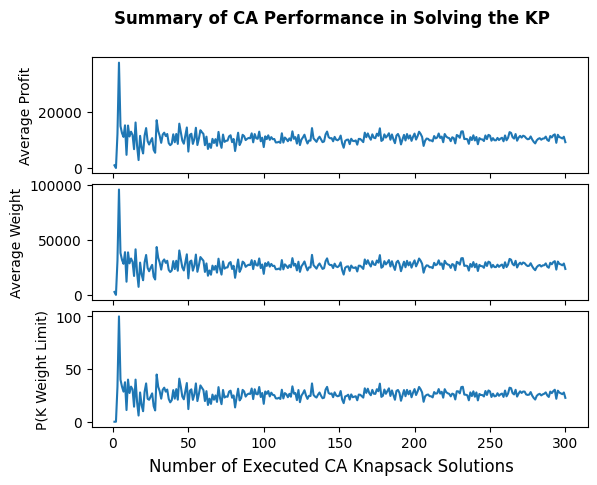

In [ ]:
results, solutions = test_analysis(8, 3, PIs, kp_limit, 300)
import matplotlib.pyplot as plt
fig = plt.figure()
gs = fig.add_gridspec(3, hspace = 0.095) # 3 plots in vertical
axs = gs.subplots(sharex = True) # Share x Axis
fig.suptitle('Summary of CA Performance in Solving the KP', weight='bold')
fig.supxlabel('Number of Executed CA Knapsack Solutions')
y1 = []
y2 = []
y3 = []
for result in results:
    y1.append(result[0])
    y2.append(result[1])
    y3.append(result[3])
axs[0].plot(list(range(1, 301)), y1)
axs[1].plot(list(range(1, 301)), y2)
axs[2].plot(list(range(1, 301)), y3)

axs[0].set(ylabel = 'Average Profit')
axs[1].set(ylabel = 'Average Weight');
axs[2].set(ylabel = 'P(K Weight Limit)');